In [32]:
import numpy as np
import h5py
import os,sys
import matplotlib.pyplot as plt

In [33]:
sys.setrecursionlimit(50000)

In [34]:
def readh5(filename, datasetname='main', rr=[1,1,1]):
    fid=h5py.File(filename,'r')
    if isinstance(datasetname, (list,)):
        out = [None] *len(datasetname)
        for i,dd in enumerate(datasetname):
            sz = len(fid[dd].shape)
            if sz==2:
                out[i] = np.array(fid[dd][::rr[0],::rr[1]])
            elif sz==3:
                out[i] = np.array(fid[dd][::rr[0],::rr[1],::rr[2]])
    else:
        sz = len(fid[datasetname].shape)
        if sz==2:
            out = np.array(fid[datasetname][::rr[0],::rr[1]])
        elif sz==3:
            out = np.array(fid[datasetname][::rr[0],::rr[1],::rr[2]])
        elif sz==4:
            out = np.array(fid[datasetname][::,::rr[0],::rr[1],::rr[2]])
    return out

def writeh5(filename, dtarray, datasetname='main'): 
    fid=h5py.File(filename,'w')                                                                      
    if isinstance(datasetname, (list,)):                                                             
        for i,dd in enumerate(datasetname):                                                          
            ds = fid.create_dataset(dd, dtarray[i].shape, compression="gzip", dtype=dtarray[i].dtype)
            ds[:] = dtarray[i]                                                                       
    else:                                                                                            
        ds = fid.create_dataset(datasetname, dtarray.shape, compression="gzip", dtype=dtarray.dtype) 
        ds[:] = dtarray                                                                              
    fid.close()

def find_connected_component(label_volume, threshold = 0.1):
    """
    Find connected components
    """
    connected_components = []
    
    label_volume_copy = label_volume.copy()
    
    Z, X, Y = label_volume_copy.shape
    
    for z in range(Z):
        for x in range(X):
            for y in range(Y):
                if label_volume_copy[z,x,y] >= threshold:
                    
                    connected_component = []
                    find_connected_component_recursive(label_volume_copy, z, x, y, connected_component, threshold)
                    
                    connected_components.append(connected_component)
                    
    return connected_components
                
                
def find_connected_component_recursive(label_volume, z, x, y, connected_component, threshold):
    Z, X, Y = label_volume.shape

    if z < 0 or z >= Z or x < 0 or x >= X or y < 0 or y >= Y or (z,x,y) in connected_component or label_volume[z,x,y] < threshold:
        return
    
    label_volume[z,x,y] = 0.0
    connected_component.append((z,x,y))
    
    find_connected_component_recursive(label_volume, z+1, x, y, connected_component, threshold)
    find_connected_component_recursive(label_volume, z-1, x, y, connected_component, threshold)
    find_connected_component_recursive(label_volume, z, x+1, y, connected_component, threshold)
    find_connected_component_recursive(label_volume, z, x-1, y, connected_component, threshold)
    find_connected_component_recursive(label_volume, z, x, y+1, connected_component, threshold)
    find_connected_component_recursive(label_volume, z, x, y-1, connected_component, threshold)
    

def find_centroid(connected_component):
    length = float(len(connected_component))
    
    z_sum, x_sum, y_sum = 0.0, 0.0, 0.0
    
    for point in connected_component:
        z_sum, x_sum, y_sum = z_sum + point[0], x_sum + point[1], y_sum + point[2]
    
    return (z_sum/length, x_sum/length, y_sum/length)

def euclid_distance(a, b):
    return np.linalg.norm(np.array(list(a)) - np.array(list(b)))

def precision_recall(connected_components_prediction, connected_components_label, distance=15.385):
    """
    According to paper, (195, 195, 65)um corresponds to (300 * 300 * 100) voxels. So 10um = 15.385 voxels
    """
    matching_components = 0
    
    centroids_prediction = [find_centroid(connected_component) for connected_component in connected_components_prediction]
    centroids_label = [find_centroid(connected_component) for connected_component in connected_components_label]
    
    i = 0
    
    while True:
        
        if i >= len(centroids_prediction):
            break
        
        centroid_prediction = centroids_prediction[i]
        matching_centroid_label = None
                
        for centroid_label in centroids_label:
            
            score = euclid_distance(centroid_prediction, centroid_label)
            
            if score <= distance:
                matching_centroid_label = centroid_label
                break
                
        if matching_centroid_label != None:
            centroids_prediction.remove(centroid_prediction)
            centroids_label.remove(matching_centroid_label)
            matching_components += 1
        else:
            i += 1
            
    centroids_prediction_remaining = len(centroids_prediction)
    centroids_label_remaining = len(centroids_label)
    
    precision = float(matching_components) / (float(matching_components) + float(centroids_prediction_remaining))
    recall = float(matching_components) / (float(matching_components) + float(centroids_label_remaining))
    
    return (precision, recall)

    
def optimize_f_score(prediction_volume, label_volume, beta=2):
    """
    f_beta = (1 + beta^2) * (pr/(beta^2*p+r))
    http://www.eneuro.org/content/eneuro/4/5/ENEURO.0195-17.2017.full.pdf
    """
    f_best = 0.0
    best_threshold = None
    best_precision, best_recall = None, None
    #threshold_array = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
    threshold_array = [0.6, 0.65, 0.7, 0.75, 0.8]
    for threshold in threshold_array:
        
        connected_components = find_connected_component(prediction_volume[2], threshold=threshold)
        connected_components_label = find_connected_component(label_volume, threshold=1)
        
        precision, recall = precision_recall(connected_components, connected_components_label)
        
        f_local = (1 + beta**2) * (precision * recall) / ((beta**2)*precision + recall)
        
        print(f_local, precision, recall)
        
        if f_local > f_best:
            
            f_best = f_local
            best_threshold, best_precision, best_recall = threshold, precision, recall
            
    return (f_best, best_threshold, best_precision, best_recall)
        
                

In [46]:
prediction_volume_V3 = readh5('test_V3/result_alpha20/volume_0.h5')
prediction_volume_V2 = readh5('test_V2/result_alpha20/volume_0.h5')
prediction_volume_V1 = readh5('test_V1/result_alpha20/volume_0.h5')

V3_label_volume = readh5("V3_anno_sparse_cellcenters.h5")
V2_label_volume = readh5("V2_anno_dense_bv_cell_corrected.h5")
V1_label_volume = readh5("V1_anno_dense_bv_cell_corrected.h5")

V3_volume = readh5("V3_img.h5")
V2_volume = readh5("V2_img.h5")

In [42]:
nodes_volume

(2832, 3)

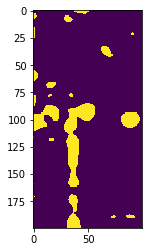

In [36]:
plt.imshow((prediction_volume_V2[2][100]>0.2).astype(np.uint8)*255)

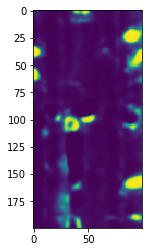

In [42]:
plt.imshow(prediction_volume_V2[1][100])

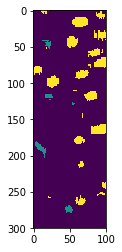

In [16]:
plt.imshow(V1_label_volume[100])

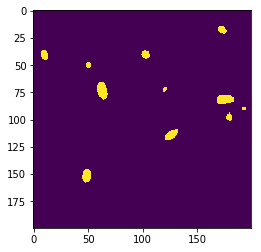

In [31]:
plt.imshow(prediction_volume_V3[1][50] > 0.9)

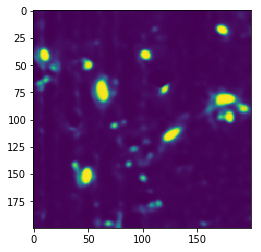

In [26]:
plt.imshow(prediction_volume_V3[1][50])

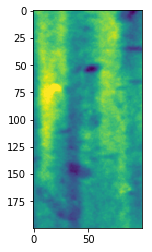

In [48]:
plt.imshow(V2_volume[10])

In [12]:
writeh5("Kasthuri_V3_bv_alpha20_prediction.h5", prediction_volume_V3[1])

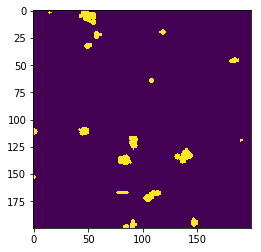

In [31]:
plt.imshow(V3_label_volume[100])

In [356]:
f2, best_threshold, best_precision, best_recall = optimize_f_score(prediction_volume_V3, V3_label_volume, beta=2)

In [357]:
print(f2, best_threshold, best_precision, best_recall)

(0.8624999999999998, 0.75, 0.7840909090909091, 0.8846153846153846)


In [ ]:
f2, best_threshold, best_precision, best_recall = optimize_f_score(prediction_volume_V2, V2_label_volume, beta=2)

In [ ]:
print(f2, best_threshold, best_precision, best_recall)

In [5]:
f2, best_threshold, best_precision, best_recall = optimize_f_score(prediction_volume_V1, V1_label_volume, beta=2)

(0.6710442024343369, 0.4524838012958963, 0.7632058287795993)
(0.6803529012555141, 0.5339547270306259, 0.7304189435336976)
(0.6938559322033898, 0.6179245283018868, 0.7158469945355191)
(0.6961566352429297, 0.6832740213523132, 0.6994535519125683)
(0.6993006993006993, 0.7293666026871402, 0.692167577413479)
(0.69660014781966, 0.7392156862745098, 0.6867030965391621)
(0.6980640357408786, 0.7653061224489796, 0.6830601092896175)
(0.6969357249626308, 0.7770833333333333, 0.6794171220400729)
(0.6952273581360391, 0.7956989247311828, 0.6739526411657559)
(0.7021837349397592, 0.8108695652173913, 0.6794171220400729)
(0.6989044200982244, 0.8203991130820399, 0.6739526411657559)
(0.6918119787717969, 0.8257918552036199, 0.6648451730418944)
(0.6905761159862649, 0.851764705882353, 0.6593806921675774)


In [6]:
print(f2, best_threshold, best_precision, best_recall)

(0.7021837349397592, 0.65, 0.8108695652173913, 0.6794171220400729)
